Copyright 2020 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Assess privacy risks with TensorFlow Privacy Membership Inference Attacks

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack/codelabs/membership_probability_codelab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack/codelabs/membership_probability_codelab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

##Overview
In this codelab we'll train a simple image classification model on the CIFAR10 dataset, and then use the "membership inference attack" against this model to assess if the attacker is able to "guess" whether a particular sample was present in the training set. We further compute each sample's probability of being in the training set, denoted as membership probability (also called privacy risk score in https://arxiv.org/abs/2003.10595)

## Setup
First, set this notebook's runtime to use a GPU, under Runtime > Change runtime type > Hardware accelerator. Then, begin importing the necessary libraries.

In [2]:
#@title Import statements.
import numpy as np
from typing import Tuple, Text
from scipy import special

import tensorflow as tf
import tensorflow_datasets as tfds

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action="ignore", category=ConvergenceWarning)
simplefilter(action="ignore", category=FutureWarning)

### Install TensorFlow Privacy.

In [3]:
!pip3 install git+https://github.com/tensorflow/privacy

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

## Train a model

In [4]:
#@markdown Train a simple model on CIFAR10 with Keras.

dataset = 'cifar10'
num_classes = 10
num_conv = 3
activation = 'relu'
lr = 0.02
momentum = 0.9
batch_size = 250
epochs = 100  # Privacy risks are especially visible with lots of epochs.


def small_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              activation: Text = 'relu') -> tf.keras.models.Sequential:
  """Setup a small CNN for image classification.

  Args:
    input_shape: Integer tuple for the shape of the images.
    num_classes: Number of prediction classes.
    num_conv: Number of convolutional layers.
    activation: The activation function to use for conv and dense layers.

  Returns:
    The Keras model.
  """
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))
  return model


print('Loading the dataset.')
train_ds = tfds.as_numpy(
    tfds.load(dataset, split=tfds.Split.TRAIN, batch_size=-1))
test_ds = tfds.as_numpy(
    tfds.load(dataset, split=tfds.Split.TEST, batch_size=-1))
x_train = train_ds['image'].astype('float32') / 255.
y_train_indices = train_ds['label'][:, np.newaxis]
x_test = test_ds['image'].astype('float32') / 255.
y_test_indices = test_ds['label'][:, np.newaxis]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train_indices, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_indices, num_classes)

input_shape = x_train.shape[1:]

model = small_cnn(
    input_shape, num_classes, num_conv=num_conv, activation=activation)

print('learning rate %f', lr)

optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=momentum)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True)
print('Finished training.')

Loading the dataset.
learning rate %f 0.02
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flat

Epoch 47/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5407 - accuracy: 0.8072 - val_loss: 1.0616 - val_accuracy: 0.6804
Epoch 48/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5302 - accuracy: 0.8108 - val_loss: 1.0639 - val_accuracy: 0.6843
Epoch 49/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5354 - accuracy: 0.8100 - val_loss: 1.0413 - val_accuracy: 0.6779
Epoch 50/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5269 - accuracy: 0.8126 - val_loss: 1.0934 - val_accuracy: 0.6748
Epoch 51/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5195 - accuracy: 0.8146 - val_loss: 1.0981 - val_accuracy: 0.6779
Epoch 52/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5171 - accuracy: 0.8161 - val_loss: 1.0979 - val_accuracy: 0.6755
Epoch 53/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5108 - accuracy: 0.8179 - val_loss: 1.0986 - val_accuracy:

## Calculate logits, probabilities and loss values for training and test sets.

We will use these values later in the membership inference attack and membership probability analysis to separate training and test samples.

In [5]:
print('Predict on train...')
logits_train = model.predict(x_train, batch_size=batch_size)
print('Predict on test...')
logits_test = model.predict(x_test, batch_size=batch_size)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

loss_train = cce(constant(y_train), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


## Run membership inference attacks.

We will now execute a membership inference attack against the previously trained CIFAR10 model. This will generate a number of scores, most notably, attacker advantage and AUC for the membership inference classifier.

An AUC of close to 0.5 means that the attack wasn't able to identify training samples, which means that the model doesn't have privacy issues according to this test. Higher values, on the contrary, indicate potential privacy issues.

For comparison with the following membership probability analysis, here we only perform threshold attack.

Best-performing attacks over all slices
  THRESHOLD_ATTACK achieved an AUC of 0.72 on slice CORRECTLY_CLASSIFIED=False
  THRESHOLD_ATTACK achieved an advantage of 0.36 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  THRESHOLD_ATTACK achieved an AUC of 0.60
  THRESHOLD_ATTACK achieved an advantage of 0.20

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK achieved an AUC of 0.61
  THRESHOLD_ATTACK achieved an advantage of 0.20

Best-performing attacks over slice: "CLASS=1"
  THRESHOLD_ATTACK achieved an AUC of 0.56
  THRESHOLD_ATTACK achieved an advantage of 0.17

Best-performing attacks over slice: "CLASS=2"
  THRESHOLD_ATTACK achieved an AUC of 0.64
  THRESHOLD_ATTACK achieved an advantage of 0.26

Best-performing attacks over slice: "CLASS=3"
  THRESHOLD_ATTACK achieved an AUC of 0.66
  THRESHOLD_ATTACK achieved an advantage of 0.30

Best-performing attacks over slice: "CLASS=4"
  THRESHOLD_ATTACK achieved an AUC of 0.62
  TH

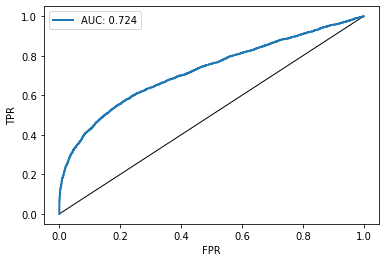

In [6]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting

labels_train = np.argmax(y_train, axis=1)
labels_test = np.argmax(y_test, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                 SlicingSpec(
                                     entire_dataset = True,
                                     by_class = True,
                                     by_classification_correctness = True
                                 ),
                                 attack_types = [
                                     AttackType.THRESHOLD_ATTACK])

# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices = True))

## Membership probability analysis

This part shows how to use the membership probability.

For each data slice, we compute membership probabilities for both training and test data. We then set a threshold on membership probability (an input is inferred as a member if and only if its membership probability is higher than the threshold) and compute the attack precision and recall values. We also report AUC and advantange values here for comparison with threshold attacks.

In [7]:
# compute membership probabilities on all given data slices
membership_probability_results = mia.run_membership_probability_analysis(input,
                                                                         SlicingSpec(
                                                                             entire_dataset = True,
                                                                             by_class = True,
                                                                             by_classification_correctness = True))
# print the summary of membership probability analysis
print(membership_probability_results.summary(threshold_list=[1, 0.9, 0.8, 0.7, 0.6, 0.5]))


Membership probability analysis over slice: "Entire dataset"
  with 0.6000 as the threshold on membership probability, the precision-recall pair is (0.6031, 0.1281)
  with 0.5000 as the threshold on membership probability, the precision-recall pair is (0.5647, 0.8502)
  thresholding on membership probability achieved an AUC of 0.62
  thresholding on membership probability achieved an advantage of 0.19

Membership probability analysis over slice: "CLASS=0"
  with 0.6000 as the threshold on membership probability, the precision-recall pair is (0.6178, 0.1956)
  with 0.5000 as the threshold on membership probability, the precision-recall pair is (0.5685, 0.8090)
  thresholding on membership probability achieved an AUC of 0.62
  thresholding on membership probability achieved an advantage of 0.20

Membership probability analysis over slice: "CLASS=1"
  with 0.6000 as the threshold on membership probability, the precision-recall pair is (0.6006, 0.0842)
  with 0.5000 as the threshold on me

## Manually plot training samples with high and low membership risks

For samples with low membership risks, I pick samples whose membership probabilities are closest to 0.5.

For data class 0
  Plot high risky training points


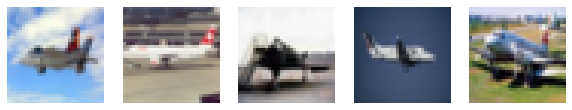

  Plot low risky training points


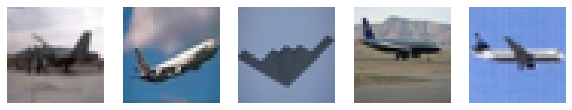

For data class 1
  Plot high risky training points


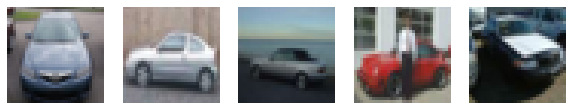

  Plot low risky training points


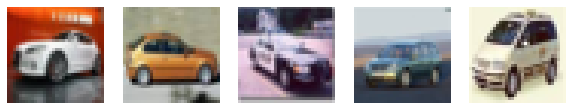

For data class 2
  Plot high risky training points


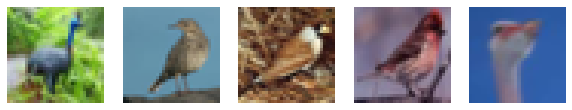

  Plot low risky training points


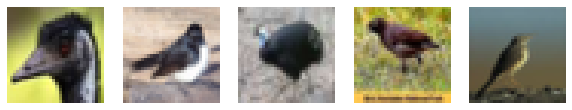

For data class 3
  Plot high risky training points


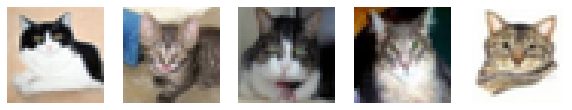

  Plot low risky training points


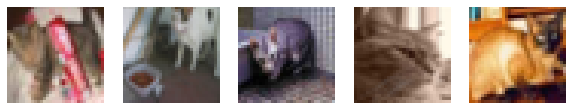

For data class 4
  Plot high risky training points


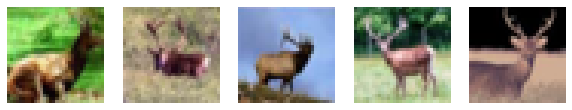

  Plot low risky training points


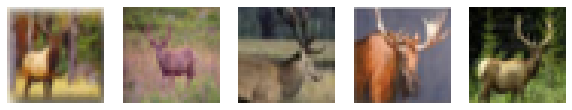

For data class 5
  Plot high risky training points


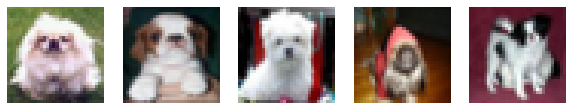

  Plot low risky training points


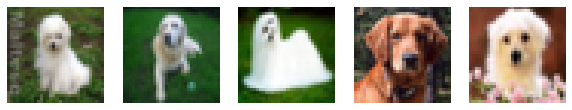

For data class 6
  Plot high risky training points


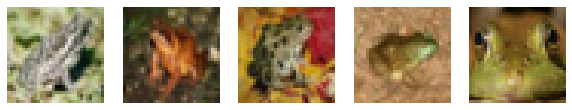

  Plot low risky training points


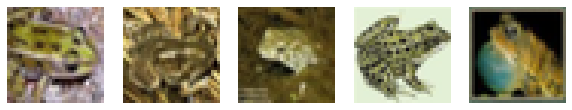

For data class 7
  Plot high risky training points


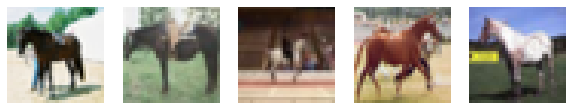

  Plot low risky training points


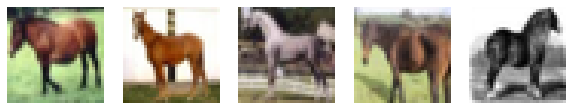

For data class 8
  Plot high risky training points


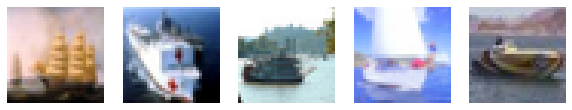

  Plot low risky training points


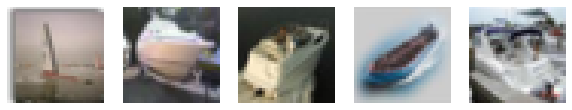

For data class 9
  Plot high risky training points


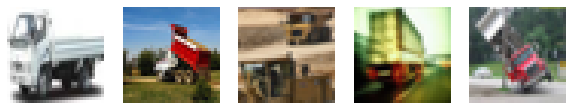

  Plot low risky training points


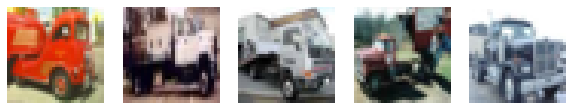

In [8]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SingleSliceSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingFeature
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.dataset_slicing import get_slice
import matplotlib.pyplot as plt
class_list = np.arange(10)
num_images = 5
for c in class_list:
    print('For data class '+str(c))
    class_slice_spec = SingleSliceSpec(SlicingFeature.CLASS, c)
    class_input_slice = get_slice(input, class_slice_spec)
    class_dataset_idx = np.argwhere(labels_train==c).flatten()

    class_train_membership_probs = mia._compute_membership_probability(class_input_slice).train_membership_probs

    class_high_risky_idx = np.argsort(class_train_membership_probs)[::-1][:num_images]
    class_low_risky_idx = np.argsort(np.absolute(class_train_membership_probs-0.5))[:num_images]
    
    high_risky_images = x_train[class_dataset_idx[class_high_risky_idx]]
    low_risky_images = x_train[class_dataset_idx[class_low_risky_idx]]
    print('  Plot high risky training points')
    fig = plt.figure(figsize=(10,10*num_images))
    for i in range(num_images):
        fig.add_subplot(1, num_images, i+1)
        plt.axis('off')
        plt.imshow(high_risky_images[i])
    plt.show()

    print('  Plot low risky training points')
    fig = plt.figure(figsize=(10,10*num_images))

    for i in range(num_images):
        fig.add_subplot(1, num_images, i+1)
        plt.axis('off')
        plt.imshow(low_risky_images[i])
    
    plt.show()